In [13]:
%matplotlib inline
import os
import random
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.segmentation import mark_boundaries
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar

USE_CV2 = True
if USE_CV2:
    from cv2 import imread # opencv is much faster, but less accurate
    MIN_OBJ_VAL = 0
else:
    from skimage.io import imread
    MIN_OBJ_VAL = 1000

### <font color = '#4A90E2'>List all the directories</font>

In [14]:
os.listdir('./input/')

['test.sh',
 'train_label',
 'train_video_list',
 'EvaluationScriptsAndExamples.zip',
 'train_color',
 'list_test',
 'test',
 'test_video_list_and_name_mapping.zip',
 'test_video_list_name_mapping',
 'EvaluationScriptsAndExamples',
 'train_label.zip',
 'convertVideotoCSV.py',
 'list_test_mapping',
 'sample_submission.csv.zip',
 'train_video_list.zip',
 'train_color.zip']

In [20]:
def filecheck(dir):
    dir_size = 0
    filelist = os.listdir(dir)
    filelist.sort()
    print(dir)
    for i,name in enumerate(filelist):
        dir_size += os.path.getsize(os.path.join(dir, name))
    print("{:.1f} GB of {} files".format(dir_size/1024/1024/1024, i))
    print("showing sample files")
    print("\n".join(filelist[300:306]) + "\n")

dirs = ["./input/train_color","./input/train_label"]

for d in dirs[0:2]:
    filecheck(d)

./input/train_color
92.3 GB of 39221 files
showing sample files
170908_061523257_Camera_5.jpg
170908_061523257_Camera_6.jpg
170908_061523396_Camera_5.jpg
170908_061523396_Camera_6.jpg
170908_061523535_Camera_5.jpg
170908_061523535_Camera_6.jpg

./input/train_label
1.0 GB of 39221 files
showing sample files
170908_061523257_Camera_5_instanceIds.png
170908_061523257_Camera_6_instanceIds.png
170908_061523396_Camera_5_instanceIds.png
170908_061523396_Camera_6_instanceIds.png
170908_061523535_Camera_5_instanceIds.png
170908_061523535_Camera_6_instanceIds.png



In [5]:
im = Image.open("./input/train_color/170908_061523396_Camera_6.jpg")

In [7]:
label = np.asarray(Image.open("./input/train_color/170908_061523396_Camera_6.jpg"))

In [ ]:
# convert image label to a numpy array
label = np.asarray(Image.open("./input/train_color/170908_061523396_Camera_6.jpg"))

In [12]:
label[label != 0]

array([ 82, 115, 160, ...,  29,  28,  33], dtype=uint8)

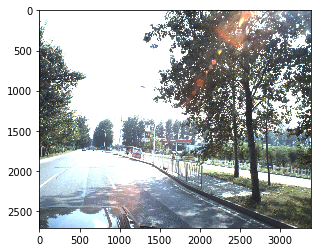

None

In [21]:
im = Image.open("./input/train_color/170908_061541188_Camera_6.jpg")
tlabel = np.asarray(Image.open("./input/train_label/170908_061523257_Camera_6_instanceIds.png")) // 1000
tlabel[tlabel != 0] = 255
plt.imshow(Image.blend(im, Image.fromarray(tlabel).convert('RGB'), alpha=0.4))
plt.imshow(im)
display(plt.show())

In [ ]:
# class dictionary 
# choose the labels from the class dict
classdict = {}
tlabel = np.asarray(Image.open(""))

In [22]:
classdict = {0:'others', 1:'rover', 17:'sky', 33:'car', 34:'motorbicycle', 35:'bicycle', 36:'person', 37:'rider', 
             38:'truck', 39:'bus', 40:'tricycle', 49:'road', 50:'siderwalk', 65:'traffic_cone'}

tlabel = np.asarray(Image.open("./input/train_label/170908_061523257_Camera_6_instanceIds.png"))
cls = np.unique(tlabel)//1000
unique, counts = np.unique(cls, return_counts=True)
d = dict(zip(unique, counts))
df = pd.DataFrame.from_dict(d, orient='index').transpose()
df.rename(columns=classdict, inplace=True)
df

,others,car,bus,tricycle
0,1,8,1,1


### <font color = '#4A90E2'>Data Preprocessing</font>

In [23]:
DATA_DIR = os.path.join('.', 'input')

In [25]:
all_paths = pd.DataFrame(dict(path = glob(os.path.join(DATA_DIR, '*', '*.*p*g'))))
all_paths['split'] = all_paths['path'].map(lambda x: x.split('/')[-2].split('_')[0])
all_paths['group'] = all_paths['path'].map(lambda x: x.split('/')[-2].split('_')[-1])
all_paths['group'] = all_paths['group'].map(lambda x: 'color' if x == 'test' else x)
all_paths['SessionId'] = all_paths['path'].map(lambda x: '_'.join(os.path.splitext(os.path.basename(x))[0].split('_')[:4]))
all_paths.sample(5)

,path,split,group,id
13496,./input/train_label/170927_064404161_Camera_6_...,train,label,170927_064404161_Camera_6
10616,./input/train_label/170908_073232068_Camera_5_...,train,label,170908_073232068_Camera_5
20995,./input/train_label/171206_033122487_Camera_6_...,train,label,171206_033122487_Camera_6
66924,./input/train_color/170927_063844445_Camera_6.jpg,train,color,170927_063844445_Camera_6
35182,./input/train_label/170908_075416768_Camera_5_...,train,label,170908_075416768_Camera_5


In [27]:
group_df = all_paths.pivot_table(values = 'path', columns = 'group', aggfunc = 'first', index = ['id', 'split']).reset_index()
group_df.sample(5)

group,id,split,color,label
22854,170927_064352193_Camera_5,train,./input/train_color/170927_064352193_Camera_5.jpg,./input/train_label/170927_064352193_Camera_5_...
30178,171206_030447439_Camera_5,train,./input/train_color/171206_030447439_Camera_5.jpg,./input/train_label/171206_030447439_Camera_5_...
33630,171206_033120999_Camera_6,train,./input/train_color/171206_033120999_Camera_6.jpg,./input/train_label/171206_033120999_Camera_6_...
38304,171206_034345655_Camera_5,train,./input/train_color/171206_034345655_Camera_5.jpg,./input/train_label/171206_034345655_Camera_5_...
18363,170908_085242269_Camera_6,train,./input/train_color/170908_085242269_Camera_6.jpg,./input/train_label/170908_085242269_Camera_6_...


39222 rows


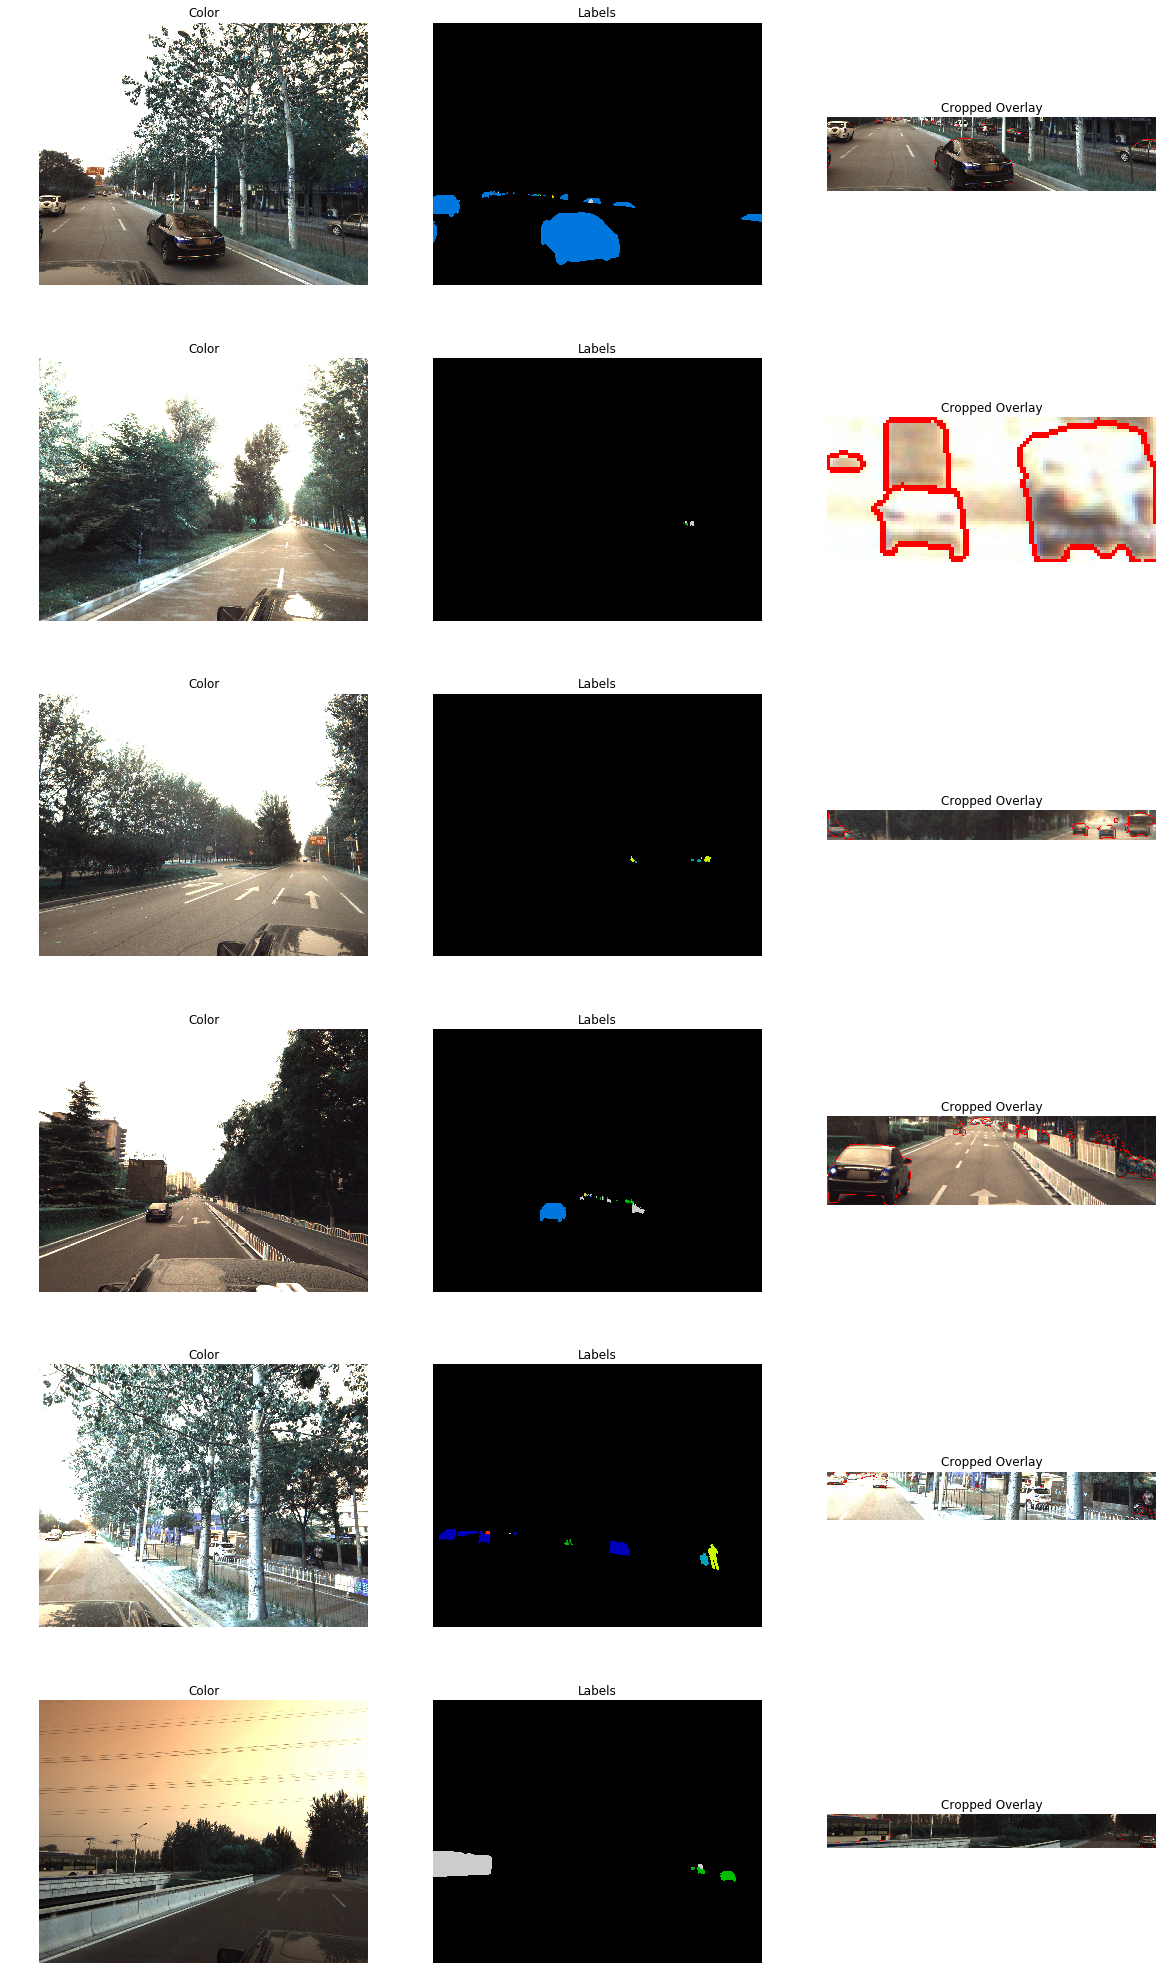

In [28]:
train_df = group_df.query('split=="train"')
print(train_df.shape[0], 'rows')
sample_rows = 6
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, train_df.sample(sample_rows).iterrows()):
    c_img = imread(c_row['color'])
    l_img = imread(c_row['label'])
    if l_img.ndim==3: l_img = l_img[:,:,0]
    ax1.imshow(c_img)
    ax1.set_title('Color')
    # make the labels nicer
    nice_limg = np.zeros(l_img.shape, dtype = np.uint8)
    for new_idx, old_idx in enumerate(np.unique(l_img[l_img>MIN_OBJ_VAL]), 1):
        nice_limg[l_img==old_idx]=new_idx
    ax2.imshow(nice_limg, cmap = 'nipy_spectral')
    ax2.set_title('Labels')
    xd, yd = np.where(l_img>MIN_OBJ_VAL)
    bound_img = mark_boundaries(image = c_img, label_img = l_img, color = (1,0,0), background_label = 255, mode = 'thick')
    ax3.imshow(bound_img[xd.min():xd.max(), yd.min():yd.max(),:])
    ax3.set_title('Cropped Overlay')

In [31]:
train_split_df, valid_split_df = train_test_split(train_df, random_state = 2018, test_size = 0.25)

In [51]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
IMG_SIZE = (384, 384) # slightly smaller than vgg16 normally expects
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)

rgb_gen = ImageDataGenerator(preprocessing_function = preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(**img_gen_args)

In [52]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [56]:
import tensorflow.keras.preprocessing as KPImage
from PIL import Image
class pil_image_awesome():
    @staticmethod
    def open(in_path):
        if 'instanceIds' in in_path:
            # we only want to keep the positive labels not the background
            in_img = imread(in_path)
            if in_img.ndim==3:
                in_img = in_img[:,:,0]
            return Image.fromarray((in_img>MIN_OBJ_VAL).astype(np.float32))
        else:
            return Image.open(in_path)
    fromarray = Image.fromarray
KPImage.pil_image = pil_image_awesome

In [57]:
from skimage.filters.rank import maximum
from scipy.ndimage import zoom
def lab_read_func(in_path):
    bin_img = (imread(in_path)>1000).astype(np.uint8)
    x_dim, y_dim = bin_img.shape
    max_label_img = maximum(bin_img, np.ones((x_dim//IMG_SIZE[0], y_dim//IMG_SIZE[1])))
    return np.expand_dims(zoom(max_label_img, (IMG_SIZE[0]/x_dim, IMG_SIZE[1]/y_dim), order = 3), -1)


def train_and_lab_gen_func(in_df, batch_size = 8, seed = None):
    if seed is None:
        seed = np.random.choice(range(1000))
    train_rgb_gen = flow_from_dataframe(rgb_gen, in_df, 
                             path_col = 'color',
                            y_col = 'id', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = batch_size,
                                   seed = seed)
    train_lab_gen = flow_from_dataframe(lab_gen, in_df, 
                             path_col = 'label',
                            y_col = 'id', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = batch_size,
                                   seed = seed)
    for (x, _), (y, _) in zip(train_rgb_gen, train_lab_gen):
        yield x, y
    
train_and_lab_gen = train_and_lab_gen_func(train_split_df, batch_size = 32)
valid_and_lab_gen = train_and_lab_gen_func(valid_split_df, batch_size = 32)

In [58]:
(rgb_batch, lab_batch) = next(valid_and_lab_gen)

sample_rows = 4
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img[:,:,0], cmap = 'nipy_spectral')
    ax2.set_title('Labels')
    if lab_img.max()>0.1:
        xd, yd = np.where(lab_img[:,:,0]>0)
        bound_img = mark_boundaries(image = r_rgb_img, label_img = lab_img[:,:,0], 
                                    color = (1,0,0), background_label = 255, mode = 'thick')
        ax3.imshow(bound_img[xd.min():xd.max(), yd.min():yd.max(),:])
        ax3.set_title('Cropped Overlay')

## Ignore next message from keras, values are replaced anyways: seed: 341
Found 0 images belonging to 0 classes.
Reinserting dataframe: 9806 images
## Ignore next message from keras, values are replaced anyways: seed: 341
Found 0 images belonging to 0 classes.
Reinserting dataframe: 9806 images


ValueError: could not convert string to float: '170927_064228854_Camera_5'

In [46]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Build U-Net model
inputs = Input(IMG_SIZE+(3,))
s = BatchNormalization()(inputs) # we can learn the normalization step
s = Dropout(0.5)(s)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_v2_2 (Batch (None, 384, 384, 3)  12          input_3[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 384, 384, 3)  0           batch_normalization_v2_2[0][0]   
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 8)  224         dropout_2[0][0]                  
______________________________________________________________________________________________

In [47]:
import tensorflow as tf
from tensorflow.keras import backend as K
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

model.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'binary_accuracy', 'mse'])

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('unet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

W0314 18:07:04.484745 140213293098368 callbacks.py:1443] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


In [49]:
# reset the generators so they all have different seeds when multiprocessing lets loose
batch_size = 16
train_and_lab_gen = train_and_lab_gen_func(train_split_df, batch_size = batch_size)
valid_and_lab_gen = train_and_lab_gen_func(valid_split_df, batch_size = batch_size)
model.fit_generator(train_and_lab_gen, 
                    steps_per_epoch = 2048//batch_size,
                    validation_data = valid_and_lab_gen,
                    validation_steps = 256//batch_size,
                    epochs = 3, 
                    workers = 4,
                    use_multiprocessing = True,
                    callbacks = callbacks_list)

W0314 18:07:19.700706 140213293098368 training_generator.py:409] Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence` class.


Epoch 1/3
## Ignore next message from keras, values are replaced anyways: seed: 941
## Ignore next message from keras, values are replaced anyways: seed: 941
## Ignore next message from keras, values are replaced anyways: seed: 941
## Ignore next message from keras, values are replaced anyways: seed: 941
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Reinserting dataframe: 29416 images
Reinserting dataframe: 29416 images
Reinserting dataframe: 29416 images
## Ignore next message from keras, values are replaced anyways: seed: 941
## Ignore next message from keras, values are replaced anyways: seed: 941
Reinserting dataframe: 29416 images
## Ignore next message from keras, values are replaced anyways: seed: 941
## Ignore next message from keras, values are replaced anyways: seed: 941
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belon

ValueError: could not convert string to float: '170927_064515411_Camera_5'

In [55]:
(rgb_batch, lab_batch) = next(valid_and_lab_gen)
sample_rows = 5
fig, m_axs = plt.subplots(sample_rows, 5, figsize = (20, 6*sample_rows))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax2_pred, ax3, ax3_pred), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    lab_pred = model.predict(np.expand_dims(rgb_img, 0))[0]
    
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img[:,:,0], cmap = 'jet')
    ax2.set_title('Labels')
    ax2_pred.imshow(lab_pred[:,:,0], cmap = 'jet')
    ax2_pred.set_title('Pred Labels')
    if lab_img.max()>0.1:
        xd, yd = np.where(lab_img[:,:,0]>0)
        bound_img = mark_boundaries(image = r_rgb_img, label_img = lab_img[:,:,0], 
                                    color = (1,0,0), background_label = 255, mode = 'thick')
        ax3.imshow(bound_img[xd.min():xd.max(), yd.min():yd.max(),:])
        ax3.set_title('Cropped Overlay')
        ax3_pred.imshow(lab_pred[xd.min():xd.max(), yd.min():yd.max(),0], cmap = 'jet')
        ax3_pred.set_title('Cropped Overlay')
fig.savefig('trained_model.png')

## Ignore next message from keras, values are replaced anyways: seed: 941
Found 0 images belonging to 0 classes.
Reinserting dataframe: 9806 images
## Ignore next message from keras, values are replaced anyways: seed: 941
Found 0 images belonging to 0 classes.
Reinserting dataframe: 9806 images


ValueError: could not convert string to float: '170927_064011944_Camera_6'